# Week 4 - Partial Least Squares Regression

In [31]:
import scipy as sp, numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
import matplotlib.pyplot as plt

r2ycalc = lambda Ypred, YY: 1 - np.sum((scale(Ypred) - YY)**2) / np.sum(YY**2)

data = loadmat('./data/wk4_Cosgrove-data.mat', squeeze_me=True)['s']

X = data['X'].item() # the untransformed data matrix (66x102)
Y = data['Y'].item() # the untransformed LDH release at 48hours. (66x1)
phosphoproteins = data['phosphoproteins'].item() # names of phosphoproteins
conditions = data['conditions'].item() # cell array of the 66 conditions
drugList = data['drugList'].item() # description of the drugs used in each of the 66 conditions
drugListToxic = data['drugListToxic'].item() # binary value corresponding to whether drugList[i] is toxic
drugs = data['drugs'].item() # binary matrix mapping which measurements correspond to a drug treatment in drugList
cytokineList = data['cytokineList'].item() # cell array of cytokine treatments
ind4pProtein = data['ind4pProtein'].item() # the column indices corresponding to measurements of the 4 phosphoprotein subset

#### (1) Perform PLSR on the matrixes X and Y. Plot the percent variance explained. How many principle components do you need for each to explain 90% of the variance? Discuss your findings.

Hint: Be sure to normalize each dataset as needed for the analysis.

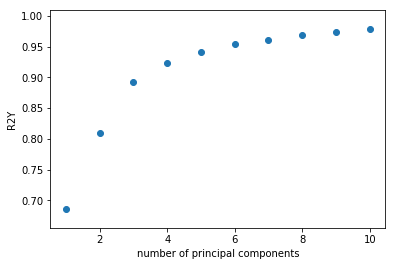

In [11]:
Y_zs = scale(Y[:, -1])
X_zs = scale(X)

R2Y = np.zeros(10)
for i in range(R2Y.size):
    PLS = PLSRegression(n_components=i + 1)

    PLS.fit(X_zs, Y_zs)

    R2Y[i] = PLS.score(X_zs, Y_zs)

plt.scatter(np.arange(R2Y.size) + 1, R2Y);
plt.xlabel("number of principal components");
plt.ylabel("R2Y");

Need 4 components. Additional components will always increase R2Y, because it is not calculated in crossvalidation.

#### (2) Recreate the Figure S2A plot from Cosgrove et al. supplementary information. This is the PLSR scores plot (for PC1 and PC2), with toxic drugs colored according to the drug type and all other drugs are not colored. Use the drugList, drugListToxic to identify these categories.

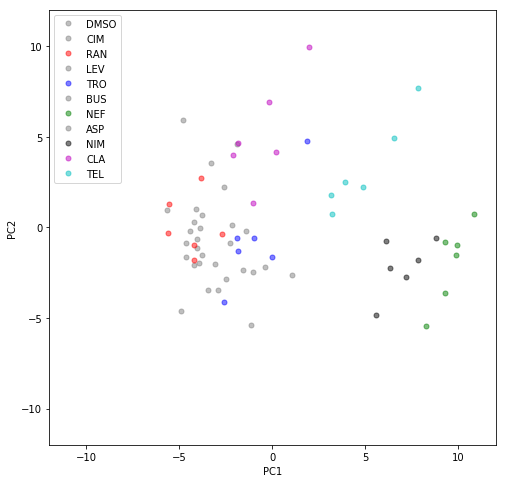

In [14]:
PLS = PLSRegression(n_components=4)
xScores, yScores = PLS.fit_transform(X_zs, Y_zs)

toxMask = drugListToxic
tox_iters = np.arange(11)[toxMask==1]
colors = ['r','b','g','k','m','c']
c_indx = -1

#plot the drug scores (PCs) one at a time
plt.figure(figsize=(8,8))
for indx in np.arange(drugs.shape[1]): #numbers between 0 and 10
    #Check whether the drug is toxic or not and select corresponding color.
    if indx not in tox_iters:
        C = 'gray'
        alph = 0.5
    else:
        c_indx +=1
        C = colors[c_indx]
    mask = drugs[:,indx]==1
    xVals = xScores[:,0]
    yVals = xScores[:,1]
    drugX = xVals[mask]
    drugY = yVals[mask]
    plt.plot(drugX, drugY, '.', markersize = 10, c=C, alpha = alph, label = drugList[indx])

plt.xlim(-12,12);
plt.ylim(-12,12);
plt.xlabel("PC1");
plt.ylabel("PC2");
plt.legend(loc = 2);

#### (3) Create the loadings plot corresponding to (2). Interpret the results shown on the plot.

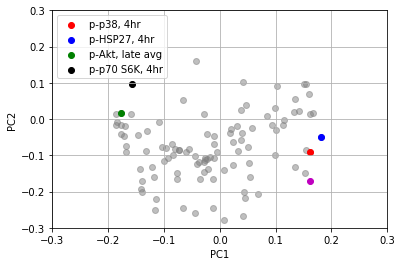

In [49]:
# # Answer. phosphoproteins variable, a list of 102 protein names. interpret: pick on of the points and increased it in this direction, what would happen in terms of the output
#what is a loading matrix and if a point is point in it then what does it mean
loadings = PLS.x_loadings_
yloadings = PLS.y_loadings_

plt.scatter(loadings[:,0],loadings[:,1], c = 'gray', alpha = 0.5)
plt.scatter(loadings[:,0][79], loadings[:,1][79], c = 'r', label = 'p-p38, 4hr')
plt.scatter(loadings[:,0][85], loadings[:,1][85], c = 'b', label ='p-HSP27, 4hr' )
plt.scatter(loadings[:,0][34], loadings[:,1][34], c = 'g', label = 'p-Akt, late avg')
plt.scatter(loadings[:,0][37], loadings[:,1][37], c = 'k', label = 'p-p70 S6K, 4hr')

plt.scatter(yloadings[:,0], yloadings[:,1], c = 'm')

plt.grid();
plt.xlim(-0.3,0.3);
plt.ylim(-0.3,0.3);
plt.xlabel("PC1");
plt.ylabel("PC2");
plt.legend(loc = 2);

The loadings (1) show the directions of maximal covariance, and (2) define the predicted relationship between X and y. For example, here, increases in pAkt and/or pS6K are predicted to decrease LDH release.

#### (4) Recreate a 4-principle component model using PLSR with just the final 4 phosphoprotein model. Plot predicted LDH versus observed LDH for this model. Report the model fitness (R^2). Define here how you are calculating R^2.

R2Y is:  0.893872712689992


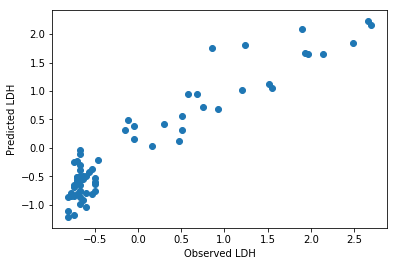

In [18]:
zX4phospho = scale(X[:, ind4pProtein-1])

PLS = PLSRegression(n_components=4)
PLS.fit(zX4phospho, Y_zs)

Y_predict = PLS.predict(zX4phospho)
R2Y = PLS.score(zX4phospho, Y_zs)
print("R2Y is: ", R2Y)

plt.scatter(Y_zs, Y_predict);
plt.xlabel("Observed LDH");
plt.ylabel("Predicted LDH");

#### (5) Cosgrove reported that the 4-phosphoprotein model chosen, based on VIP scores, accurately reproduces LDH release. To determine if the VIP score improved the selection of reduced parameter sets, choose 4 phosphoproteins at random (keeping all measurements per phosphoprotein) and calculate the fitness by calculating the R^2 value for each set. Repeat this 100 times and calculate the model fitness (R^2) and plot the histogram of these values. Do you think the VIP-score based model reduction is better than random selections? Why/ why not? Do you need to keep track of the 100 subsets chosen in your random trials to prevent choosing the same subset? Why/why not?

In [ ]:
# SKIP

#### (6) Cosgrove et al. Discusses their method for model validation using leave- one-out cross-validation. Calculate all LDH predictions for leave-one-out cross-validation and calculate the R^2 value for the resulting yfit values. What is the R^2 value? Why do you think it’s important to perform cross-validation?

0.8418732886804305


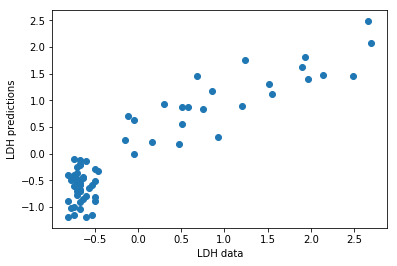

In [30]:
Yloo = np.zeros_like(Y_zs)

xscaler = StandardScaler()
yscaler = StandardScaler()
PLS = PLSRegression(n_components = 4)

for train_index, test_index in LeaveOneOut().split(X):
    y_train = yscaler.fit_transform(np.expand_dims(Y_zs[train_index], axis=1))
    
    PLS.fit(xscaler.fit_transform(X[train_index]), y_train)
    
    Yloo[test_index] = yscaler.inverse_transform(PLS.predict(xscaler.transform(X[test_index])))

print(r2ycalc(Yloo, Y_zs))

plt.scatter(Y_zs, Yloo);
plt.xlabel("LDH data");
plt.ylabel("LDH predictions");

Can see here that the R2Y value upon crossvalidation (also called Q2Y) is lower than the direct fit. Crossvalidation helps ensure that we're building a model able to predict new conditions. This also helps ensure we are not overfitting.

#### (7) Now, instead of performing LOOCV, let's perform leave-one-cytokine-out cross-validation. That is, one cytokine at a time, leave out all the data for the `NoCyt`, `IL-1`, `LPS`, `TNF`, `IL-6`, or `Mix` conditions.

Hint: Look at `sklearn.model_selection.LeaveOneGroupOut`.

How does this affect your cross-validation? How do the two approaches here differ? When might each be most appropriate?

0.8587511977708243


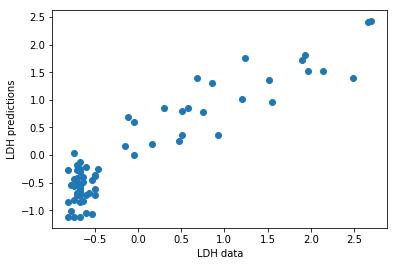

In [37]:
groups = np.tile(np.arange(1,7), 11)
Ylogo = np.zeros_like(Y_zs)

for train_index, test_index in LeaveOneGroupOut().split(X, groups=groups):
    y_train = yscaler.fit_transform(np.expand_dims(Y_zs[train_index], axis=1))
    
    PLS.fit(xscaler.fit_transform(X[train_index]), y_train)
    
    Ylogo[test_index] = np.squeeze(yscaler.inverse_transform(PLS.predict(xscaler.transform(X[test_index]))))

print(r2ycalc(Ylogo, Y_zs))

plt.scatter(Y_zs, Ylogo);
plt.xlabel("LDH data");
plt.ylabel("LDH predictions");

Here, the effect on prediction error ended up being minor. LOO is leaving out a single condition, but still offers training information about the cytokine condition left out. Therefore, it wouldn't be justified to argue we'd built a model able to predict the effects of entirely new cytokines. In LOGO, we've shown the ability to predict effects with entirely unseen cytokines, so this lends confidence we could predict new ones.